In [1]:
import os
os.chdir('/home/soham/Desktop/GitHub/BTP/scripts/Mixture + Analytes/3 Analytes/')

from utils import add_noise, plot_pca_decision_boundary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import re

import warnings
warnings.filterwarnings('ignore')
os.chdir('/home/soham/Desktop/GitHub/BTP/')

In [2]:
total_data = pd.read_csv('data/labelled/labelled.csv')
total_data.head()

,CFU/mL,Sensor2,Sensor1,Sensor3,label
0,30500000.0,70.734,-68.02,52.47,1
1,3050000.0,50.162,-95.70,32.63,1
2,305000.0,-8.390,-99.96,-10.41,1
3,30500.0,-18.700,-107.42,-23.93,1
4,3050.0,-19.620,-109.94,-27.24,1


## PCA

In [3]:
total_data = total_data.drop(['CFU/mL'], axis=1)
labels = total_data['label']

total_data.head()

,Sensor2,Sensor1,Sensor3,label
0,70.734,-68.02,52.47,1
1,50.162,-95.70,32.63,1
2,-8.390,-99.96,-10.41,1
3,-18.700,-107.42,-23.93,1
4,-19.620,-109.94,-27.24,1


In [4]:
X = total_data[['Sensor1','Sensor2','Sensor3']]
Y = total_data['label']
label_mapping = {1: 'A1', 2: 'A2', 3: 'A3'}

pca  = PCA(n_components=2)
pca.fit(X)
pca_data = pca.transform(X)
pca_data = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])

X_train, X_test, Y_train, Y_test = train_test_split(pca_data, Y, test_size=0.3, random_state=np.random.randint(0,100))

pca_data.head()

,PC1,PC2
0,-22.442149,55.984647
1,-43.457599,24.248253
2,-31.610782,-43.949584
3,-36.054776,-61.840659
4,-38.263527,-65.442300


### RFC

In [5]:
rfc = RFC(n_estimators=100)
rfc.fit(X_train, Y_train)

print('Training accuracy = ', rfc.score(X_train, Y_train))

pred = rfc.predict(X_test)
print('Testing accuracy = ', accuracy_score(Y_test, pred))

Training accuracy =  1.0
Testing accuracy =  0.9565217391304348


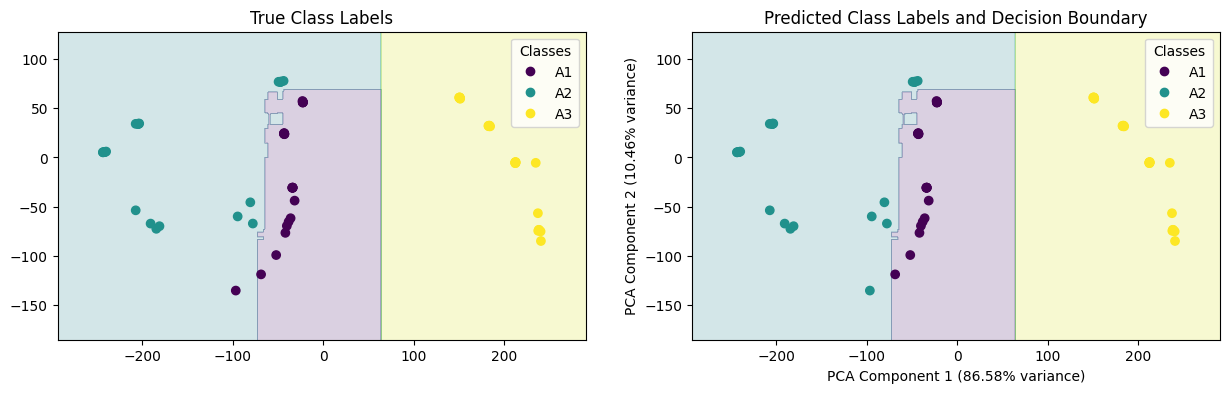

In [6]:
pca_data['Labels'] = total_data['label'].map(label_mapping)
plot_pca_decision_boundary(pca, pca_data, rfc, label_mapping)

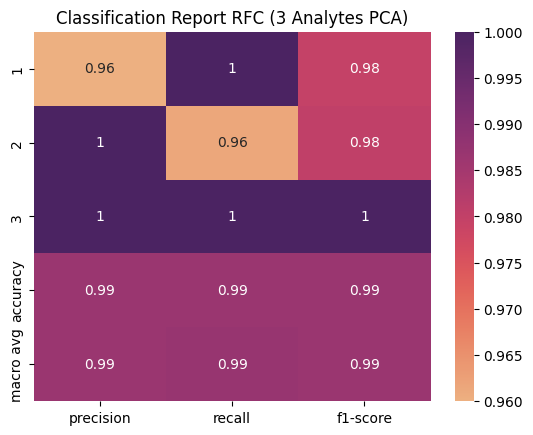

In [7]:
''' Confusion matrix '''

predictions = rfc.predict(pca_data[['PC1','PC2']])
report = classification_report(predictions, Y, output_dict=True)
report = pd.DataFrame(report).transpose()

sns.heatmap(report.iloc[:-1, :-1], annot=True, cmap='flare')
plt.title('Classification Report RFC (3 Analytes PCA)')
plt.show()

## Adding Additional Noise Points

Noise level = 0.05
Training accuracy = 1.0
Test accuracy = 1.0


<Figure size 1000x800 with 0 Axes>

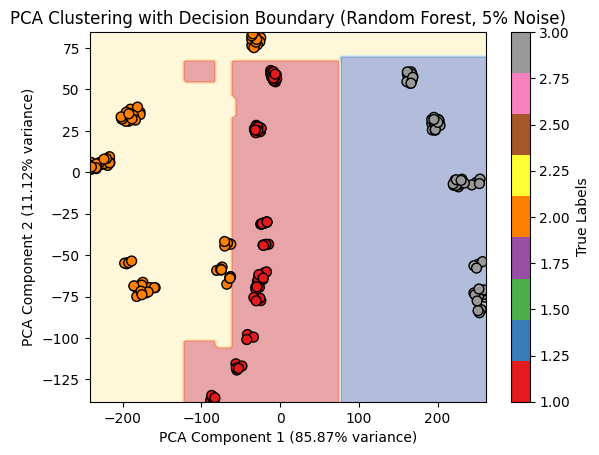

Noise level = 0.1
Training accuracy = 1.0
Test accuracy = 0.9428571428571428


<Figure size 1000x800 with 0 Axes>

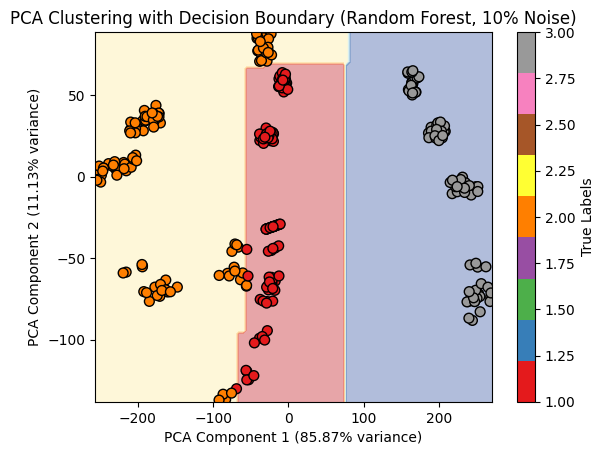

Noise level = 0.15
Training accuracy = 1.0
Test accuracy = 0.9714285714285714


<Figure size 1000x800 with 0 Axes>

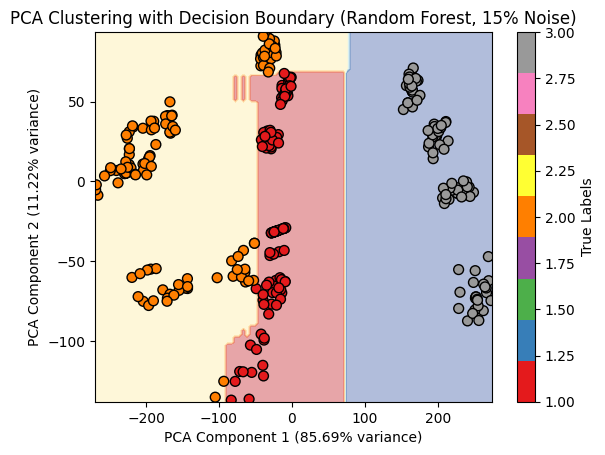

Noise level = 0.2
Training accuracy = 1.0
Test accuracy = 0.9714285714285714


<Figure size 1000x800 with 0 Axes>

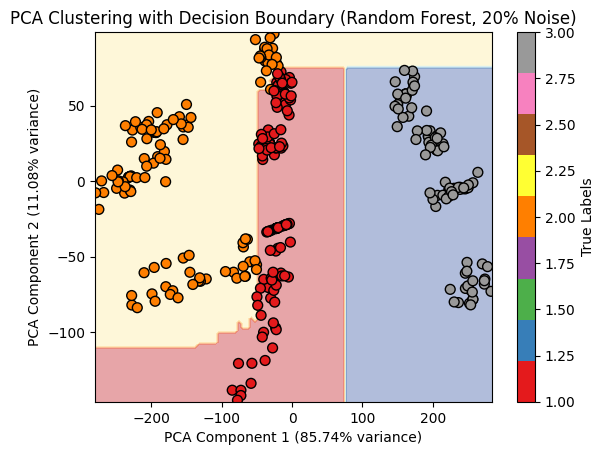

Noise level = 0.25
Training accuracy = 1.0
Test accuracy = 0.9619047619047619


<Figure size 1000x800 with 0 Axes>

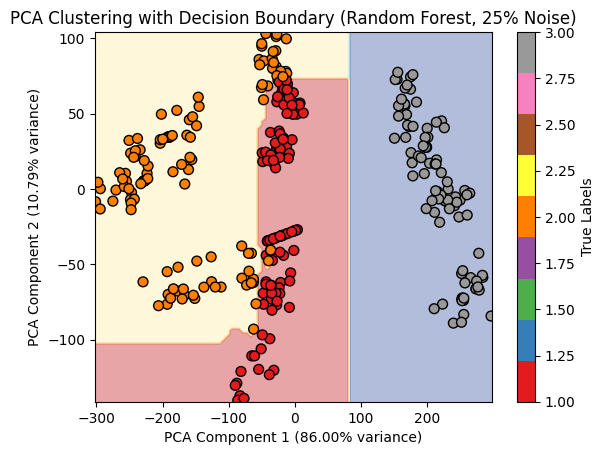

Noise level = 0.3
Training accuracy = 1.0
Test accuracy = 0.9523809523809523


<Figure size 1000x800 with 0 Axes>

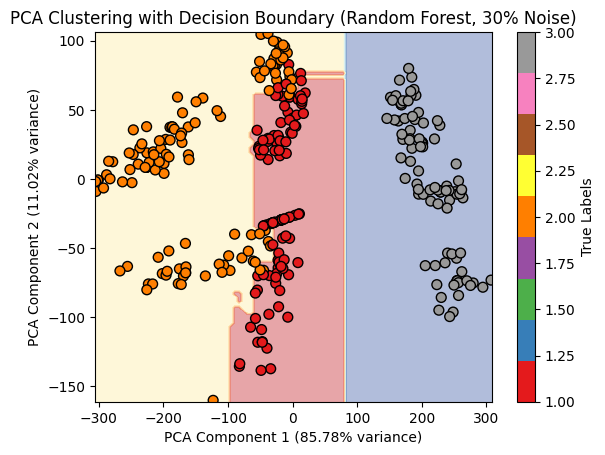

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay


def add_noise(data, labels, noise_level, target_size=350):
    combined_data = data.copy()
    combined_labels = labels.copy()

    while len(combined_data) < target_size:
        noisy_data = data.copy()
        new_data_points = []

        for sensor in ['Sensor1', 'Sensor2', 'Sensor3']:
            noise = np.random.uniform(-noise_level, noise_level, size=noisy_data.shape[0])
            new_data = noisy_data[sensor] + (noisy_data[sensor] * noise)
            new_data_points.append(new_data)

        new_data_df = pd.DataFrame({
            'Sensor1': new_data_points[0],
            'Sensor2': new_data_points[1],
            'Sensor3': new_data_points[2]
        })
        new_labels = labels.copy()

        combined_data = pd.concat([combined_data, new_data_df], ignore_index=True)
        combined_labels = pd.concat([combined_labels, new_labels], ignore_index=True)

    combined_data = combined_data.iloc[:target_size]
    combined_labels = combined_labels.iloc[:target_size]

    return combined_data, combined_labels



def apply_rf_pca_and_plot(combined_data, noise_level):

    # Adding noise to the data

    noisy_data, noisy_labels = add_noise(combined_data[['Sensor1','Sensor2','Sensor3']], combined_data['label'], noise_level)
    X_pca = pca.fit_transform(noisy_data)  

    # Split into training and testing data

    X_train, X_test, y_train, y_test = train_test_split(X_pca, noisy_labels, test_size=0.3, random_state=42)

    # Random Forest

    rf_classifier_pca = RFC(n_estimators=100, random_state=42)
    rf_classifier_pca.fit(X_train, y_train)  
    
    train_pred = rf_classifier_pca.predict(X_train)
    print('Training accuracy =',accuracy_score(y_train, train_pred))

    y_pred = rf_classifier_pca.predict(X_test)
    print('Test accuracy =',accuracy_score(y_test, y_pred))


    # Plotting
    all_predicted_labels = rf_classifier_pca.predict(X_pca)

    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    Z = rf_classifier_pca.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    DecisionBoundaryDisplay.from_estimator(rf_classifier_pca, X_pca, grid_resolution=100, cmap=plt.cm.RdYlBu, alpha=0.4)

    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=all_predicted_labels, cmap=plt.cm.Set1, edgecolor='k', s=50)
    plt.title(f'PCA Clustering with Decision Boundary (Random Forest, {noise_level*100:.0f}% Noise)')
    plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0] * 100:.2f}% variance)')
    plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1] * 100:.2f}% variance)')
    plt.colorbar(label='True Labels')
    plt.legend()
    plt.show()



noise_levels = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
for noise in noise_levels:
    print("Noise level =", noise)
    apply_rf_pca_and_plot(noise)